In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib
import sys, os
from pathlib import Path

# Find the repository root by searching upward for expected folders (models and data)
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.train import aggregate_features

# Build an absolute, portable path to the model and verify it exists
model_path = repo_root / "models" / "best_model_20251112T182538Z.joblib"
model = joblib.load(model_path)

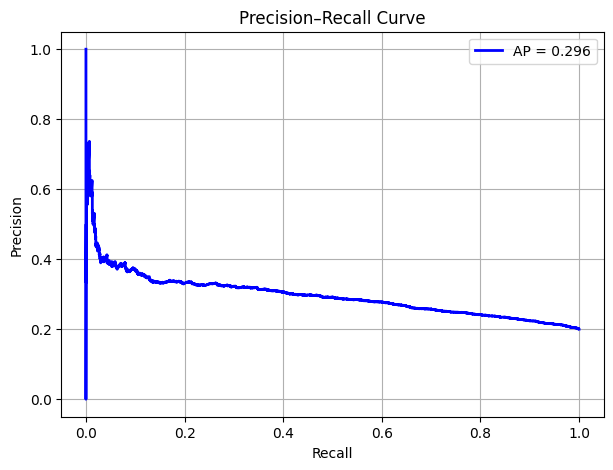

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib
import sys, os

# Find the repository root by searching upward for expected folders (models and data)
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.train import aggregate_features

# Build an absolute, portable path to the model and verify it exists
model_path = repo_root / "models" / "best_model_20251112T182538Z.joblib"
model = joblib.load(model_path)
# Load the previously saved model (will be used below as `model`)


train_dir = os.path.join(repo_root, "data", "train")
test_dir = os.path.join(repo_root, "data", "test")

train = aggregate_features(train_dir)
test = aggregate_features(test_dir)

feature_cols = [
    c
    for c in train.columns
    if c not in ["member_id", "signup_date", "churn", "outreach"]
]

X_train = train[feature_cols]
y_train = train["churn"].astype(int)
X_test = test[feature_cols]
y_test = test["churn"].astype(int)


# Probabilities from model
y_prob = model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions, color="blue", linewidth=2, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\elad\AppData\Local\Temp\ipykernel_7592\3135624242.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


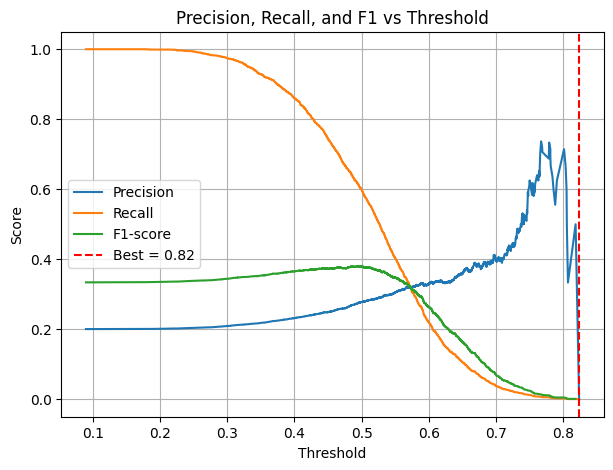

In [30]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = f1_scores.argmax()

plt.figure(figsize=(7, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.axvline(
    thresholds[best_idx],
    color="red",
    linestyle="--",
    label=f"Best = {thresholds[best_idx]:.2f}",
)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

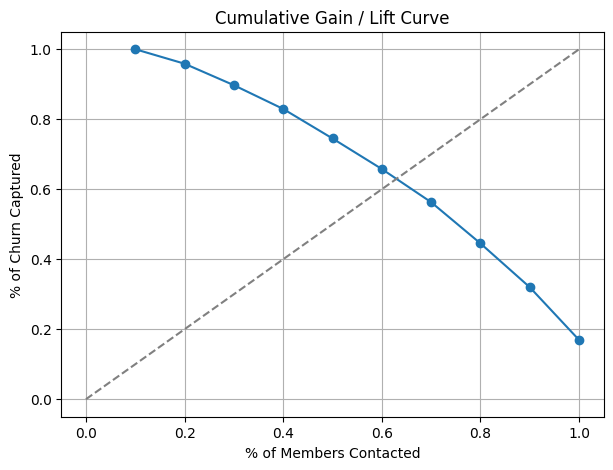

In [31]:
import pandas as pd
import numpy as np

# Build DataFrame with true label and predicted probability
df_eval = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})

# Create deciles
df_eval["decile"] = pd.qcut(df_eval["y_prob"], 10, labels=False)

# Aggregate churn rate by decile
decile_summary = (
    df_eval.groupby("decile").agg({"y_true": ["count", "sum"]}).reset_index()
)
decile_summary.columns = ["decile", "count", "churners"]

# Compute cumulative capture and lift
decile_summary = decile_summary.sort_values("decile", ascending=False)
decile_summary["cumulative_churners"] = decile_summary["churners"].cumsum()
total_churn = decile_summary["churners"].sum()
decile_summary["cumulative_perc_churn"] = (
    decile_summary["cumulative_churners"] / total_churn
)
decile_summary["perc_population"] = (decile_summary.index + 1) / 10
decile_summary["lift"] = (
    decile_summary["cumulative_perc_churn"] / decile_summary["perc_population"]
)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(
    decile_summary["perc_population"],
    decile_summary["cumulative_perc_churn"],
    marker="o",
)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("% of Members Contacted")
plt.ylabel("% of Churn Captured")
plt.title("Cumulative Gain / Lift Curve")
plt.grid(True)
plt.show()